In [3]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#https://drive.google.com/open?id=1_Xo1PTfFgY3KgPVxo5gzghj_pRzp5gCj
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1_Xo1PTfFgY3KgPVxo5gzghj_pRzp5gCj'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("images_Data.zip")
# print('Downloaded content "{}"'.format(downloaded.GetContentString()))
!unzip images_Data.zip

Archive:  images_Data.zip
  inflating: aug_images/IMG-20190708-WA0000_1.jpg  
  inflating: aug_images/IMG-20190708-WA0000_2.jpg  
  inflating: aug_images/IMG-20190708-WA0000_3.jpg  
  inflating: aug_images/IMG-20190708-WA0000_4.jpg  
  inflating: aug_images/IMG-20190708-WA0000_5.jpg  
  inflating: aug_images/IMG-20190708-WA0001_1.jpg  
  inflating: aug_images/IMG-20190708-WA0001_2.jpg  
  inflating: aug_images/IMG-20190708-WA0001_3.jpg  
  inflating: aug_images/IMG-20190708-WA0001_4.jpg  
  inflating: aug_images/IMG-20190708-WA0001_5.jpg  
  inflating: aug_images/IMG-20190708-WA0002_1.jpg  
  inflating: aug_images/IMG-20190708-WA0002_2.jpg  
  inflating: aug_images/IMG-20190708-WA0002_3.jpg  
  inflating: aug_images/IMG-20190708-WA0002_4.jpg  
  inflating: aug_images/IMG-20190708-WA0002_5.jpg  
  inflating: aug_images/IMG-20190708-WA0003_1.jpg  
  inflating: aug_images/IMG-20190708-WA0003_2.jpg  
  inflating: aug_images/IMG-20190708-WA0003_3.jpg  
  inflating: aug_images/IMG-20190708-W

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving augments_label.pickle to augments_label.pickle
Saving labels.pickle to labels.pickle
Saving model.py to model.py
Saving preprocessing.py to preprocessing.py
User uploaded file "augments_label.pickle" with length 123212 bytes
User uploaded file "labels.pickle" with length 33758 bytes
User uploaded file "model.py" with length 862 bytes
User uploaded file "preprocessing.py" with length 1092 bytes


In [1]:
import os
print(len(os.listdir("./images")))
!cp -a ./aug_images/. ./images/
print(len(os.listdir("./images")))

1065
1065


In [2]:
!ls

adc.json	       images		model.py	  sample_data
aug_images	       images_Data.zip	preprocessing.py
augments_label.pickle  labels.pickle	__pycache__


In [3]:
import keras as ks
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle as pkl

Using TensorFlow backend.


In [0]:
from sklearn.svm import SVC

In [0]:
from model import create_model
from preprocessing import preprocess

In [6]:
orig_labels=[]
with open("./labels.pickle","rb") as file:
    orig_labels=pkl.load(file)
    
aug_labels=[]
with open("./augments_label.pickle","rb") as file:
    aug_labels=pkl.load(file)
    
labels=orig_labels+aug_labels
np.random.shuffle(labels)
len(labels)

1065

In [7]:
total_data=0
ones=[]
for image in labels:
    total_data+=image[1][0]
    ones+=image[1][-1]
total_data,(np.array(ones)=='1').sum()


(1920, 786)

In [0]:
# model = SVC(kernal = "Linear", probability=True)
# model.fit()

In [0]:
# import keras as ks
# # import tensorflow as tf
# x=[]

# def create_model(input_shape):
#     base_model=ks.applications.VGG16(include_top=False,input_shape=input_shape)

#     trainable=False
#     for layer in base_model.layers:
#         if layer.name == "block5_conv1":
#             trainable=True
#         layer.trainable=trainable

#     model=ks.models.Sequential()
#     model.add(base_model)
    
    
# #     model.add(ks.layers.Dense(512,activation="relu"))
# #     model.add(ks.layers.Dense(128,activation="relu"))
# #     model.add(ks.layers.Dense(64,activation="relu"))
# #     model.add(ks.layers.Dense(1,activation="sigmoid"))

#     model.compile(optimizer="adam",loss=ks.losses.binary_crossentropy,metrics=["accuracy"])

#     return model

In [0]:
import keras as ks
# import tensorflow as tf

def create_model(input_shape):
    base_model=ks.applications.VGG16(include_top=False,input_shape=input_shape)

    trainable=False
    for layer in base_model.layers:
        if layer.name == "block5_conv1":
            trainable=True
        layer.trainable=trainable

    model=ks.models.Sequential()
    model.add(base_model)
    model.add(ks.layers.Flatten())
    model.add(ks.layers.Dropout(rate=0.25))
    model.add(ks.layers.Dense(1024,activation="relu"))
    model.add(ks.layers.Dense(512,activation="relu"))
    model.add(ks.layers.Dense(128,activation="relu"))
    model.add(ks.layers.Dense(64,activation="relu"))
    model.add(ks.layers.Dense(1,activation="sigmoid"))

    model.compile(optimizer="adamax",loss=ks.losses.binary_crossentropy,metrics=["accuracy"])

    return model

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dense_12 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
__________

In [0]:
model=create_model((224,224,3))

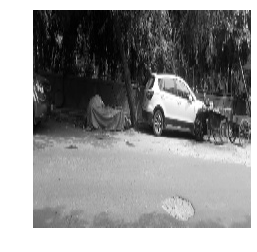

In [29]:
img = cv2.imread("./images/IMG-20190708-WA0004_1.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.axis("off")
plt.imshow(img,cmap="gray")

In [30]:
batch_size=200
epochs=5
steps_per_epoch=int(total_data/(batch_size))
steps_per_epoch

9

In [31]:
model.fit_generator(preprocess(labels,"./images/",batch_size=batch_size),steps_per_epoch=steps_per_epoch,epochs=20)

Epoch 1/20
9/9 [==============================] - 25s 3s/step - loss: 2.0505 - acc: 0.5588
Epoch 2/20
9/9 [==============================] - 24s 3s/step - loss: 0.6801 - acc: 0.5921
Epoch 3/20
9/9 [==============================] - 24s 3s/step - loss: 0.6783 - acc: 0.5886
Epoch 4/20
9/9 [==============================] - 23s 3s/step - loss: 0.6676 - acc: 0.5929
Epoch 5/20
9/9 [==============================] - 24s 3s/step - loss: 0.6355 - acc: 0.6061
Epoch 6/20
9/9 [==============================] - 24s 3s/step - loss: 0.6502 - acc: 0.5795
Epoch 7/20
9/9 [==============================] - 24s 3s/step - loss: 0.6015 - acc: 0.6471
Epoch 8/20
9/9 [==============================] - 21s 2s/step - loss: 0.5386 - acc: 0.6665
Epoch 9/20
9/9 [==============================] - 25s 3s/step - loss: 0.5297 - acc: 0.7168
Epoch 10/20
9/9 [==============================] - 22s 2s/step - loss: 0.4588 - acc: 0.7661
Epoch 11/20
9/9 [==============================] - 25s 3s/step - loss: 0.4377 - acc: 0.77

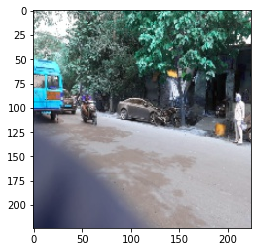

In [24]:
img=cv2.resize(cv2.imread("./aug_images/IMG-20190708-WA0008_4.jpg"),(224,224))
plt.imshow(img)

In [25]:
model.predict([[img]])

array([[0.43942687]], dtype=float32)

In [0]:
del model